In [1]:
!pip install pandas pandas-datareader tqdm --quiet

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt

import warnings, os
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)

PATH_MSF = "/content/drive/MyDrive/MSF_1996_2023.csv"


# columns at least: ['PERMNO','date','RET','PRC','SHROUT','SICCD']
df = pd.read_csv(PATH_MSF, parse_dates=['date'])
df = df.sort_values(['PERMNO','date']).reset_index(drop=True)

# Basic cleaning / coercions
for col in ['RET','PRC','SHROUT','SICCD']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# CRSP PRC often negative for bid/ask; take abs for price level use
if 'PRC' in df.columns:
    df['PRC'] = df['PRC'].abs()

# Market cap (note: SHROUT units depend on your extract; keep consistent with prior work)
if {'PRC','SHROUT'}.issubset(df.columns):
    df['MKT_CAP'] = df['PRC'] * df['SHROUT']

print("MSF head:")
display(df.head(3))
print("Shape:", df.shape)
print("Date range:", df['date'].min(), "→", df['date'].max())
print("Firms (PERMNO):", df['PERMNO'].nunique())


MSF head:


,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,RETX,vwretd,MKT_CAP
0,10001,1996-01-31,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.75,9.50,9.12500,168.0,-0.026667,8.75,9.50,2281.0,-0.026667,0.028121,20814.12500
1,10001,1996-02-29,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.75,9.50,9.25000,524.0,0.013699,9.25,9.75,2281.0,0.013699,0.016353,21099.25000
2,10001,1996-03-29,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,9.25,9.75,9.48438,283.0,0.036149,9.00,9.50,2309.0,0.025338,0.010914,21899.43342


Shape: (1636563, 19)
Date range: 1996-01-31 00:00:00 → 2023-12-29 00:00:00
Firms (PERMNO): 15862


In [2]:
# Create next-month return within each firm
df = df.sort_values(['PERMNO','date']).copy()
df['RET_next'] = df.groupby('PERMNO')['RET'].shift(-1)

# Binary jump indicator: 1 if absolute next-month return > 10%, else 0
df['jump'] = (df['RET_next'].abs() > 0.10).astype(int)

# Drop rows where we don't know next month's return (last obs per firm)
df = df[~df['RET_next'].isna()].copy()

# Quick sanity checks
overall_jump_rate = df['jump'].mean()
print(f"Overall jump rate: {overall_jump_rate:.4%}")

# Check a few firms
sample_permnos = df['PERMNO'].dropna().unique()[:3]
display(
    df[df['PERMNO'].isin(sample_permnos)]
      .loc[:, ['PERMNO','date','RET','RET_next','jump']]
      .head(12)
)

# Keep handy copies for later steps
df_base = df.copy()


Overall jump rate: 38.5131%


,PERMNO,date,RET,RET_next,jump
0,10001,1996-01-31,-0.026667,0.013699,0
1,10001,1996-02-29,0.013699,0.036149,0
2,10001,1996-03-29,0.036149,-0.070840,0
3,10001,1996-04-30,-0.070840,-0.021277,0
4,10001,1996-05-31,-0.021277,-0.060290,0
5,10001,1996-06-28,-0.060290,0.023438,0
6,10001,1996-07-31,0.023438,0.038168,0
7,10001,1996-08-30,0.038168,0.041765,0
8,10001,1996-09-30,0.041765,-0.028571,0
9,10001,1996-10-31,-0.028571,0.029412,0


[*********************100%***********************]  1 of 1 completed

Timeline shape: (335, 6)
Date coverage: 1996-01-31 00:00:00 → 2023-11-30 00:00:00


,JumpRate_%,CPI,UNRATE,VIX,USREC,SP500_YF
date,,,,,,
1996-01-31,32.923121,154.4,5.6,12.53,0,636.020020
1996-02-29,33.198905,154.9,5.5,17.04,0,640.429993
1996-03-31,39.213724,155.7,5.5,18.88,0,645.500000
1996-04-30,36.162047,156.3,5.6,15.83,0,654.169983
1996-05-31,36.570625,156.6,5.6,16.07,0,669.119995
1996-06-30,45.388587,156.7,5.3,13.68,0,670.630005
1996-07-31,35.106974,157.0,5.5,19.46,0,639.950012
1996-08-31,34.819211,157.3,5.1,17.01,0,651.989990
1996-09-30,38.223140,157.8,5.2,16.95,0,687.330017


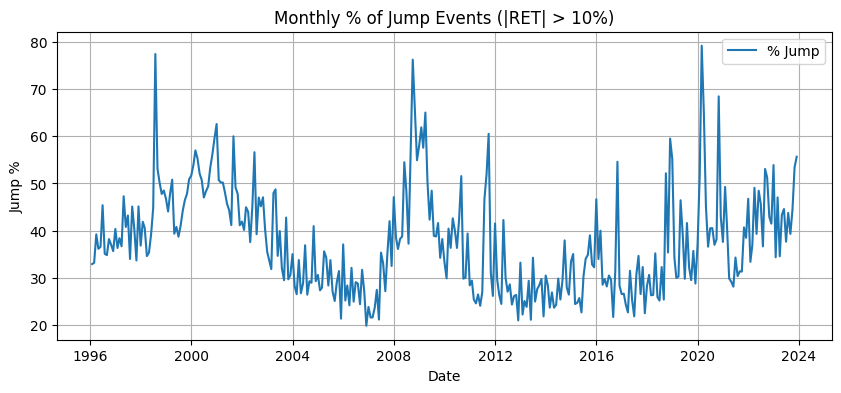

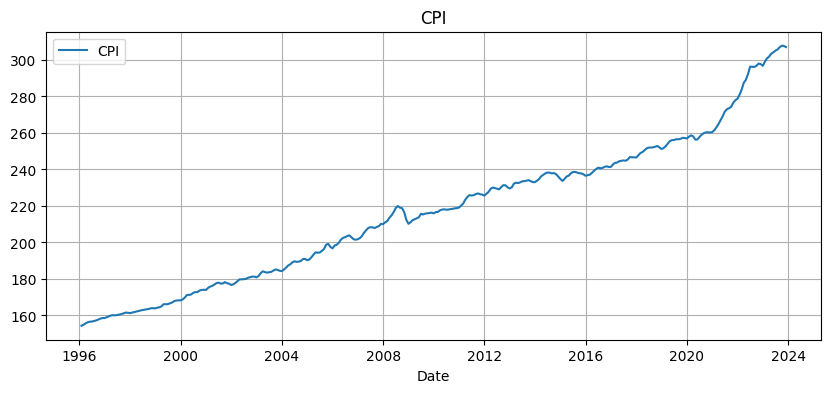

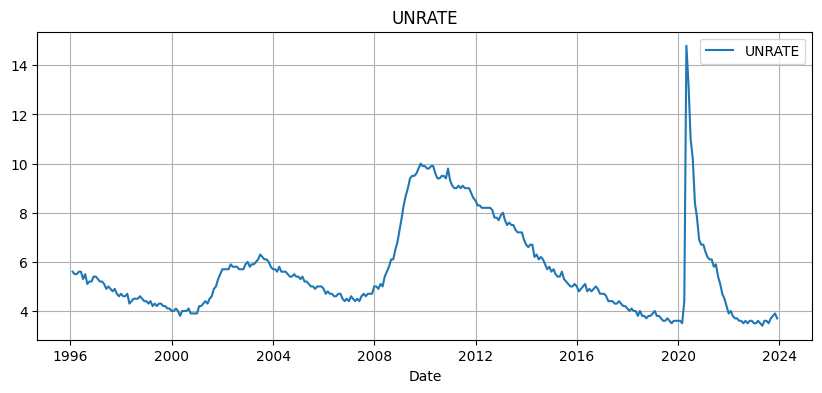

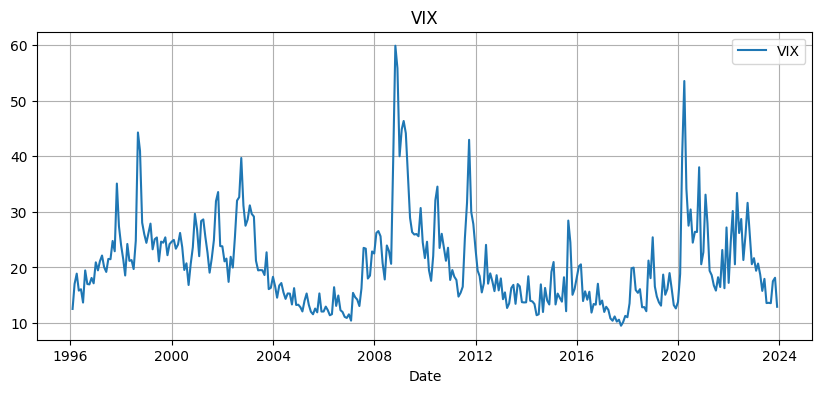

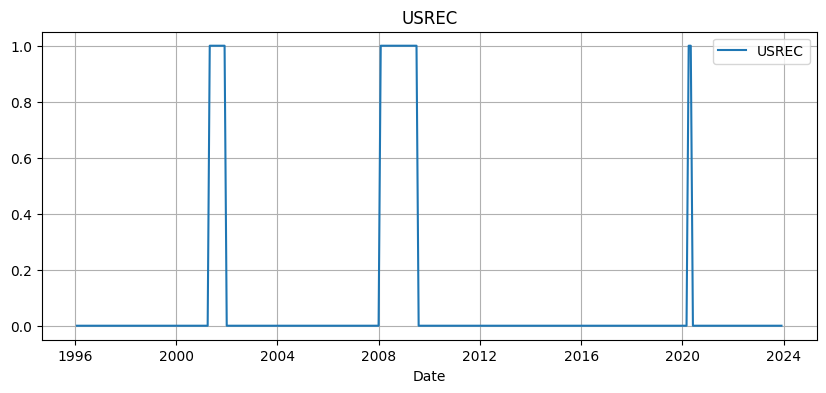

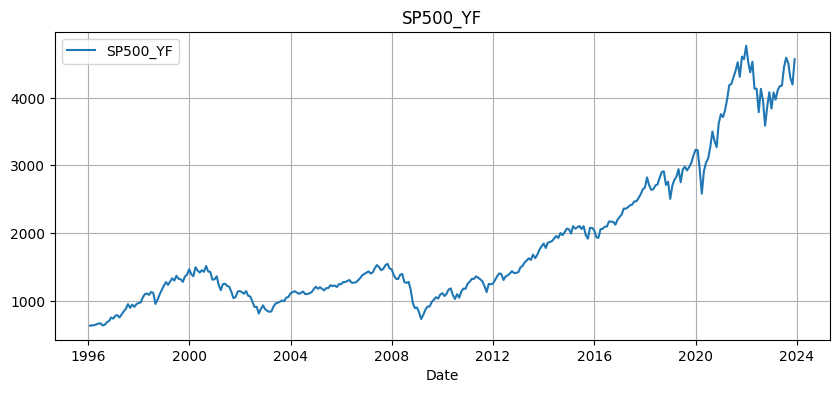

In [3]:
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr

# --- Jump rate per month ---
jump_rate = df.groupby('date')['jump'].mean().mul(100).to_frame('JumpRate_%')
jump_rate.index = jump_rate.index.to_period('M').to_timestamp('M')

# --- Helper for FRED monthly series ---
def monthly_series(series_id, colname):
    s = pdr.DataReader(series_id, 'fred',
                       start=dt.datetime(1996,1,1),
                       end=dt.datetime(2023,12,31))
    s.index = pd.to_datetime(s.index)
    s = s.resample('M').last()
    s.columns = [colname]
    return s

# --- Macro series from FRED ---
macro = pd.concat([
    monthly_series('CPIAUCNS', 'CPI'),
    monthly_series('UNRATE', 'UNRATE'),
    monthly_series('VIXCLS', 'VIX'),
    monthly_series('USREC', 'USREC')
], axis=1)

# --- S&P500 from Yahoo Finance ---
sp500_yf = yf.download("^GSPC", start="1996-01-01", end="2023-12-31")

# If MultiIndex, flatten
if isinstance(sp500_yf.columns, pd.MultiIndex):
    sp500_yf.columns = sp500_yf.columns.get_level_values(0)

# Use Close and resample to month-end
sp500_monthly = sp500_yf["Close"].resample("M").last().to_frame("SP500_YF")

# Join S&P500 to macro
macro = macro.join(sp500_monthly, how="left")

# --- Build final timeline ---
timeline = jump_rate.join(macro, how="left")

print("Timeline shape:", timeline.shape)
print("Date coverage:", timeline.index.min(), "→", timeline.index.max())
display(timeline.head(12))

# --- Plot Jump Rate ---
plt.figure(figsize=(10,4))
plt.plot(timeline.index, timeline['JumpRate_%'], label='% Jump')
plt.title("Monthly % of Jump Events (|RET| > 10%)")
plt.xlabel("Date"); plt.ylabel("Jump %")
plt.legend(); plt.grid(True)
plt.show()

# --- Plot each macro series ---
for col in ['CPI','UNRATE','VIX','USREC','SP500_YF']:
    if col in timeline.columns:
        plt.figure(figsize=(10,4))
        plt.plot(timeline.index, timeline[col], label=col)
        plt.title(col)
        plt.xlabel("Date")
        plt.legend()
        plt.grid(True)
        plt.show()


In [4]:
# --- Step 3: Feature / Covariate Construction ---

# 1) Rolling firm-level features
def add_firm_features(g, lookbacks=(3,6,12)):
    g = g.sort_values('date')

    # Lagged returns
    g['ret_lag1'] = g['RET'].shift(1)
    g['ret_lag3'] = g['RET'].shift(3)

    # Rolling volatility & momentum
    for w in lookbacks:
        g[f'vol_{w}m'] = g['RET'].rolling(w).std()
        g[f'mom_{w}m'] = g['RET'].rolling(w).sum()

    # Price level & market cap
    g['log_prc'] = np.log1p(g['PRC'])
    g['log_mktcap'] = np.log1p(g['MKT_CAP'])

    return g

df_feat = df.groupby('PERMNO', group_keys=False).apply(add_firm_features)

# 2) Merge macro indicators (already monthly)
macro_m = macro.copy()
macro_m.index = macro_m.index.to_period('M').to_timestamp('M')

df_feat['date_m'] = df_feat['date'].dt.to_period('M').dt.to_timestamp('M')
df_feat = df_feat.merge(macro_m, left_on='date_m', right_index=True, how='left')

# 3) Industry dummies (from SIC → industry mapping)
def sic_to_industry(sic):
    try:
        sic = int(sic)
    except:
        return np.nan
    if 1 <= sic <= 999: return 'Agriculture'
    if 1000 <= sic <= 1499: return 'Mining'
    if 1500 <= sic <= 1799: return 'Construction'
    if 2000 <= sic <= 3999: return 'Manufacturing'
    if 4000 <= sic <= 4999: return 'Transportation'
    if 5000 <= sic <= 5199: return 'Wholesale'
    if 5200 <= sic <= 5999: return 'Retail'
    if 6000 <= sic <= 6799: return 'Finance'
    if 7000 <= sic <= 8999: return 'Services'
    if 9000 <= sic <= 9999: return 'PublicAdmin'
    return np.nan

df_feat['industry'] = df_feat['SICCD'].apply(sic_to_industry)
df_feat = pd.get_dummies(df_feat, columns=['industry'], dummy_na=True)

# 4) Drop rows missing key features (need enough history)
df_feat = df_feat.dropna(subset=['ret_lag1','vol_3m','mom_3m','jump'])

print("Feature dataframe shape:", df_feat.shape)
display(df_feat.head(10))


Feature dataframe shape: (1535255, 48)


,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,SHROUT,RETX,vwretd,MKT_CAP,RET_next,jump,ret_lag1,ret_lag3,vol_3m,mom_3m,vol_6m,mom_6m,vol_12m,mom_12m,log_prc,log_mktcap,date_m,CPI,UNRATE,VIX,USREC,SP500_YF,industry_Agriculture,industry_Construction,industry_Finance,industry_Manufacturing,industry_Mining,industry_PublicAdmin,industry_Retail,industry_Services,industry_Transportation,industry_Wholesale,industry_nan
2,10001,1996-03-29,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,9.250,9.750,9.48438,283.0,0.036149,9.000,9.500,2309.0,0.025338,0.010914,21899.43342,-0.070840,0,0.013699,NaN,0.031831,0.023181,NaN,NaN,NaN,NaN,2.349887,9.994262,1996-03-31,155.7,5.5,18.88,0,645.500000,False,False,False,False,False,False,False,False,True,False,False
3,10001,1996-04-30,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.625,9.375,8.81250,327.0,-0.070840,8.625,9.000,2309.0,-0.070840,0.025560,20348.06250,-0.021277,0,0.036149,-0.026667,0.056417,-0.020992,NaN,NaN,NaN,NaN,2.283657,9.920790,1996-04-30,156.3,5.6,15.83,0,654.169983,False,False,False,False,False,False,False,False,True,False,False
4,10001,1996-05-31,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.625,9.000,8.62500,103.0,-0.021277,8.625,9.000,2309.0,-0.021277,0.026810,19915.12500,-0.060290,0,-0.070840,0.013699,0.053543,-0.055968,NaN,NaN,NaN,NaN,2.264364,9.899285,1996-05-31,156.6,5.6,16.07,0,669.119995,False,False,False,False,False,False,False,False,True,False,False
5,10001,1996-06-28,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.000,9.000,8.00000,338.0,-0.060290,8.000,8.250,2321.0,-0.072464,-0.008289,18568.00000,0.023438,0,-0.021277,0.036149,0.026108,-0.152407,0.041299,-0.129226,NaN,NaN,2.197225,9.829249,1996-06-30,156.7,5.3,13.68,0,670.630005,False,False,False,False,False,False,False,False,True,False,False
6,10001,1996-07-31,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.000,8.375,8.18750,207.0,0.023438,8.000,8.375,2321.0,0.023438,-0.053851,19003.18750,0.038168,0,-0.060290,-0.070840,0.041896,-0.058129,0.044958,-0.079121,NaN,NaN,2.217844,9.852415,1996-07-31,157.0,5.5,19.46,0,639.950012,False,False,False,False,False,False,False,False,True,False,False
7,10001,1996-08-30,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.000,8.750,8.50000,507.0,0.038168,8.250,8.750,2321.0,0.038168,0.032451,19728.50000,0.041765,0,0.023438,-0.021277,0.053106,0.001316,0.048828,-0.054652,NaN,NaN,2.251292,9.889870,1996-08-31,157.3,5.1,17.01,0,651.989990,False,False,False,False,False,False,False,False,True,False,False
8,10001,1996-09-30,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.250,8.750,8.75000,205.0,0.041765,8.250,8.750,2346.0,0.029412,0.052985,20527.50000,-0.028571,0,0.038168,-0.060290,0.009711,0.103371,0.049911,-0.049036,NaN,NaN,2.277267,9.929569,1996-09-30,157.8,5.2,16.95,0,687.330017,False,False,False,False,False,False,False,False,True,False,False
9,10001,1996-10-31,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.250,8.750,8.50000,203.0,-0.028571,8.250,8.750,2346.0,-0.028571,0.013673,19941.00000,0.029412,0,0.041765,0.023438,0.039611,0.051362,0.041585,-0.006767,NaN,NaN,2.251292,9.900583,1996-10-31,158.3,5.2,18.11,0,705.270020,False,False,False,False,False,False,False,False,True,False,False
10,10001,1996-11-29,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.250,8.750,8.75000,374.0,0.029412,8.250,8.750,2346.0,0.029412,0.065594,20527.50000,-0.059429,0,-0.028571,0.038168,0.037554,0.042606,0.041821,0.043922,NaN,NaN,2.277267,9.929569,1996-11-30,158.6,5.4,17.14,0,757.020020,False,False,False,False,False,False,False,False,True,False,False
11,10001,1996-12-31,11,4920.0,EWST,ENERGY WEST INC,7953,36720410,8.125,8.750,8.12500,380.0,-0.059429,8.125,8.625,2357.0,-0.071429,-0.011381,19150.62500,0.061538,0,0.029412,0.041765,0.045105,-0.058588,0.041544,0.044783,0.042299,-0.084443,2.211018,9.860143,1996-12-31,158.6,5.4,20.92,0,740.739990,False,False,False,False,False,False,False,False,True,False,False


In [5]:
# === FAST CAPM FEATURES (vectorized; no Python loops over windows) ===
def add_capm_features_fast(df, window=36):
    """
    Vectorized rolling CAPM features per firm:
      beta      = Cov(Ri, Rm) / Var(Rm)
      sys_vol   = beta^2 * Var(Rm)
      idio_vol  = Var(Ri) - sys_vol
    Uses rolling sums/means to avoid per-window OLS. Requires columns: ['PERMNO','date','RET','vwretd'].
    """
    df = df.sort_values(['PERMNO','date']).copy()

    # prepare helper columns (float64 to avoid dtype surprises)
    df['_ri']     = df['RET'].astype('float64')
    df['_rm']     = df['vwretd'].astype('float64')
    df['_ri_rm']  = df['_ri'] * df['_rm']
    df['_ri2']    = df['_ri'] ** 2
    df['_rm2']    = df['_rm'] ** 2

    g = df.groupby('PERMNO', group_keys=False)

    # rolling sums (faster than mean; we divide by window after)
    S_ri    = g['_ri'].transform(lambda s: s.rolling(window, min_periods=window).sum())
    S_rm    = g['_rm'].transform(lambda s: s.rolling(window, min_periods=window).sum())
    S_ri_rm = g['_ri_rm'].transform(lambda s: s.rolling(window, min_periods=window).sum())
    S_ri2   = g['_ri2'].transform(lambda s: s.rolling(window, min_periods=window).sum())
    S_rm2   = g['_rm2'].transform(lambda s: s.rolling(window, min_periods=window).sum())

    # convert to rolling means
    W = float(window)
    mean_ri = S_ri / W
    mean_rm = S_rm / W

    # rolling cov/var via moments
    cov_im = (S_ri_rm / W) - (mean_ri * mean_rm)
    var_m  = (S_rm2   / W) - (mean_rm ** 2)
    var_i  = (S_ri2   / W) - (mean_ri ** 2)

    # beta and vols
    beta = cov_im / var_m
    beta = beta.where(var_m > 0)  # avoid div-by-zero/infinite
    sys_vol  = (beta ** 2) * var_m
    idio_vol = (var_i - sys_vol).clip(lower=0)

    # attach and clean helpers
    df['beta']     = beta
    df['sys_vol']  = sys_vol
    df['idio_vol'] = idio_vol

    df.drop(columns=['_ri','_rm','_ri_rm','_ri2','_rm2'], inplace=True)
    return df

# --- Call this RIGHT AFTER Step 3 (df_feat is ready) ---
df_feat = add_capm_features_fast(df_feat, window=36)

print("Added CAPM features. Sample:")
display(df_feat[['PERMNO','date','beta','sys_vol','idio_vol']].head(10))


Added CAPM features. Sample:


,PERMNO,date,beta,sys_vol,idio_vol
2,10001,1996-03-29,NaN,NaN,NaN
3,10001,1996-04-30,NaN,NaN,NaN
4,10001,1996-05-31,NaN,NaN,NaN
5,10001,1996-06-28,NaN,NaN,NaN
6,10001,1996-07-31,NaN,NaN,NaN
7,10001,1996-08-30,NaN,NaN,NaN
8,10001,1996-09-30,NaN,NaN,NaN
9,10001,1996-10-31,NaN,NaN,NaN
10,10001,1996-11-29,NaN,NaN,NaN
11,10001,1996-12-31,NaN,NaN,NaN


In [6]:
# Are we computing before sampling? (should be ~1.5M rows, not ~31k)
print("df_feat rows:", df_feat.shape[0])

# Check missing RET / vwretd rates
print("Missing RET%:", df_feat['RET'].isna().mean())
print("Missing vwretd%:", df_feat['vwretd'].isna().mean())

# How many non-NaN betas overall (should be plenty after 36 months)
print("Non-null beta count:", df_feat['beta'].notna().sum())

# Show a firm with long history to visually verify
some_permno = df_feat['PERMNO'].value_counts().index[0]
display(df_feat[df_feat['PERMNO']==some_permno][['date','RET','vwretd','beta']].tail(15))


df_feat rows: 1535255
Missing RET%: 0.0
Missing vwretd%: 0.0
Non-null beta count: 1065648


,date,RET,vwretd,beta
1384,2022-09-30,-0.126552,-0.091323,0.582424
1385,2022-10-31,0.140110,0.077394,0.639022
1386,2022-11-30,0.111171,0.052354,0.676092
1387,2022-12-30,-0.082978,-0.057119,0.697480
1388,2023-01-31,-0.042816,0.071823,0.650556
1389,2023-02-28,-0.014585,-0.024666,0.665822
1390,2023-03-31,0.054599,0.023950,0.460685
1391,2023-04-28,0.033599,0.008976,0.475672
1392,2023-05-31,0.004896,0.000708,0.483364
1393,2023-06-30,0.033193,0.066183,0.485159


In [7]:
# Step 4: Sample 100 firms per year (robust to missing CAPM early months)

from numpy.random import default_rng

def sample_100_firms_per_year(
    df_in,
    min_months_per_year=8,   # require at least this many months in that year to be eligible
    require_beta=False,      # set True to prefer firms with CAPM beta present that year
    seed=42
):
    # Work on a copy; add year for reporting
    df = df_in.copy()
    df['year'] = df['date'].dt.year

    out_list = []
    for y, g in df.groupby('year', sort=True):
        # Keep rows that already have the core features present
        core_ok = g.dropna(subset=['ret_lag1', 'vol_3m', 'mom_3m', 'jump'])

        # Optionally require beta present in that year
        if require_beta and 'beta' in core_ok.columns:
            core_ok = core_ok[core_ok['beta'].notna()]

        # Eligible firms = those with at least N valid months in that year
        counts = core_ok.groupby('PERMNO').size()
        eligible_permnos = counts[counts >= min_months_per_year].index.values

        # Fallbacks if the filter is too strict
        if eligible_permnos.size == 0:
            # relax beta requirement if it was on
            relaxed = g.dropna(subset=['ret_lag1', 'vol_3m', 'mom_3m', 'jump'])
            eligible_permnos = relaxed['PERMNO'].unique()
        if eligible_permnos.size == 0:
            # ultimate fallback: all firms seen that year
            eligible_permnos = g['PERMNO'].unique()

        # Sample up to 100 firms (or fewer if not enough)
        k = min(100, eligible_permnos.size)
        rng = default_rng(seed + int(y))
        chosen = rng.choice(eligible_permnos, size=k, replace=False)

        out_list.append(g[g['PERMNO'].isin(chosen)])

    sampled = pd.concat(out_list, axis=0, ignore_index=True)
    return sampled.sort_values(['PERMNO','date']).reset_index(drop=True)

# --- Run AFTER CAPM features are added to df_feat ---
df_sampled = sample_100_firms_per_year(
    df_feat,
    min_months_per_year=8,   # you can set 12 if you want stricter coverage
    require_beta=False,      # set True if you want to ensure most rows have beta present
    seed=42
)

print("Original shape:", df_feat.shape)
print("Sampled shape:", df_sampled.shape)
print("Years covered:", df_sampled['year'].min(), "→", df_sampled['year'].max())
print("Unique PERMNOs per year (sample):")
display(df_sampled.groupby('year')['PERMNO'].nunique().head())


Original shape: (1535255, 51)
Sampled shape: (32983, 52)
Years covered: 1996 → 2023
Unique PERMNOs per year (sample):


,PERMNO
year,
1996,100
1997,100
1998,100
1999,100
2000,100


Shapes — train/valid/test: (25954, 41) (5956, 41) (7029, 41)
CAPM features in feature_cols? True
Logistic (updated) — AUC: 0.6931, KS: 0.2796, Misclass: 0.3678, Best thr: 0.4442
Confusion matrix:
 [[2515 1674]
 [ 911 1929]]


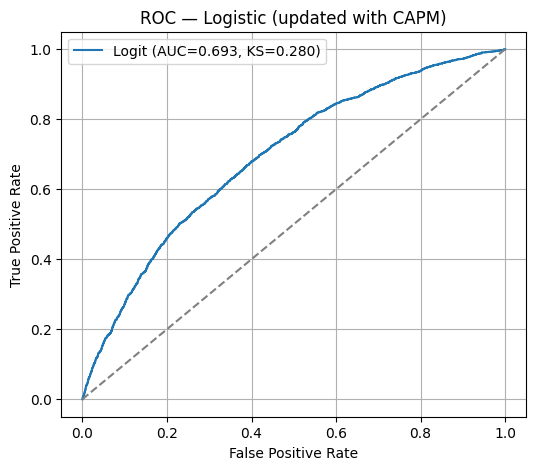

In [8]:
# --- Rebuild splits on the UPDATED df_sampled ---
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Make sure 'year' exists (sampling code usually added it, but this is safe)
if 'year' not in df_sampled.columns:
    df_sampled['year'] = df_sampled['date'].dt.year

# 1) Feature list (keep CAPM features in!)
exclude_cols = ['PERMNO','date','date_m','year','RET','RET_next','jump','SICCD','TICKER','COMNAM','CUSIP']
feature_cols = [c for c in df_sampled.columns if c not in exclude_cols]

# 2) Time splits
train_end = pd.Timestamp("2017-12-31")
val_start = pd.Timestamp("2013-01-01")
val_end   = pd.Timestamp("2017-12-31")
test_start= pd.Timestamp("2018-01-01")

df_sampled = df_sampled.sort_values("date")
train = df_sampled[df_sampled['date'] <= train_end]
valid = df_sampled[(df_sampled['date'] >= val_start) & (df_sampled['date'] <= val_end)]
test  = df_sampled[df_sampled['date'] >= test_start]

X_train, y_train = train[feature_cols], train['jump']
X_valid, y_valid = valid[feature_cols], valid['jump']
X_test,  y_test  = test[feature_cols],  test['jump']

print("Shapes — train/valid/test:", X_train.shape, X_valid.shape, X_test.shape)
print("CAPM features in feature_cols?",
      all(c in feature_cols for c in ['beta','sys_vol','idio_vol']))

# 3) Baseline Logistic with imputation + scaling
logit = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1, random_state=42))
])
logit.fit(X_train, y_train)

# 4) Evaluate on test
y_prob_test = logit.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob_test)
fpr, tpr, thr = roc_curve(y_test, y_prob_test)
ks  = (tpr - fpr).max()

best_idx = (tpr - fpr).argmax()
best_thr = thr[best_idx]
y_pred = (y_prob_test >= best_thr).astype(int)
misclass = 1 - accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Logistic (updated) — AUC: {auc:.4f}, KS: {ks:.4f}, Misclass: {misclass:.4f}, Best thr: {best_thr:.4f}")
print("Confusion matrix:\n", cm)

# ROC plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logit (AUC={auc:.3f}, KS={ks:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Logistic (updated with CAPM)")
plt.legend(); plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix

# If y_prob_test isn't in memory (e.g., you re-ran the notebook), uncomment the next line:
# y_prob_test = logit.predict_proba(X_test)[:,1]

# Recompute ROC pieces with consistent names
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
auc = roc_auc_score(y_test, y_prob_test)

# KS-optimal threshold
best_idx = (tpr - fpr).argmax()
best_threshold = thresholds[best_idx]
print(f"AUC (test): {auc:.4f}")
print(f"Optimal threshold (KS): {best_threshold:.4f}")

# Classify and report
y_pred_test = (y_prob_test >= best_threshold).astype(int)
misclass_rate = 1 - accuracy_score(y_test, y_pred_test)
print(f"Misclassification rate (test): {misclass_rate:.4f}")

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix (test):\n", cm)


AUC (test): 0.6931
Optimal threshold (KS): 0.4442
Misclassification rate (test): 0.3678
Confusion matrix (test):
 [[2515 1674]
 [ 911 1929]]


Validation AUC by C: [(0.01, np.float64(0.7338114621643168)), (0.03, np.float64(0.7338767908768523)), (0.1, np.float64(0.7333357917922828)), (0.3, np.float64(0.733043953378779)), (1.0, np.float64(0.7329563880431605))]
Best C = 0.03 (Val AUC = 0.7339)
Selected 32 features: ['SHRCD', 'PERMCO', 'BIDLO', 'ASKHI', 'VOL', 'SHROUT', 'vwretd', 'MKT_CAP', 'ret_lag3', 'vol_3m', 'mom_3m', 'vol_6m', 'mom_6m', 'vol_12m', 'mom_12m', 'log_prc', 'log_mktcap', 'CPI', 'VIX', 'USREC', 'SP500_YF', 'industry_Agriculture', 'industry_Construction', 'industry_Finance', 'industry_Mining', 'industry_PublicAdmin', 'industry_Retail', 'industry_Services', 'industry_Transportation', 'industry_Wholesale', '...']
Post-LASSO — AUC: 0.7089, KS: 0.3161, Misclass: 0.3315, Best thr: 0.4288
Confusion matrix (test):
 [[2985 1204]
 [1126 1714]]


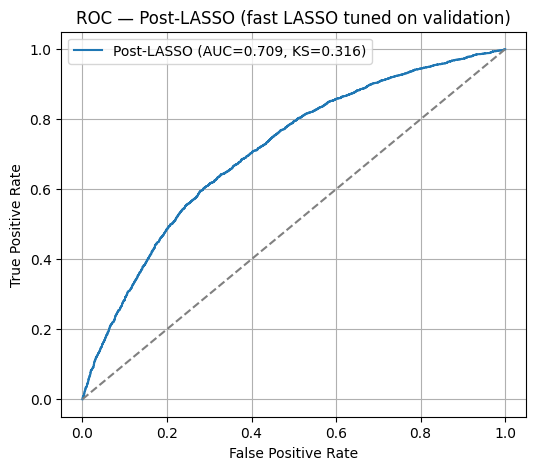

In [11]:
# === Fast LASSO + Post-LASSO (validation-tuned, no CV) ===
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# 1) Fit imputer+scaler once and reuse (faster than inside CV/pipeline each time)
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler(with_mean=False)

Xtr = scaler.fit_transform(imputer.fit_transform(X_train))
Xva = scaler.transform(imputer.transform(X_valid))
Xte = scaler.transform(imputer.transform(X_test))

# 2) Tune C on validation (small grid → fast)
C_grid = [0.01, 0.03, 0.1, 0.3, 1.0]
val_scores = []
best_model = None
best_auc = -np.inf
best_C = None

for C in C_grid:
    clf = LogisticRegression(
        penalty='l1', solver='saga',
        C=C, max_iter=300, n_jobs=-1,
        random_state=42, warm_start=True
    )
    clf.fit(Xtr, y_train)
    yva_prob = clf.predict_proba(Xva)[:,1]
    auc_va = roc_auc_score(y_valid, yva_prob)
    val_scores.append((C, auc_va))
    if auc_va > best_auc:
        best_auc = auc_va
        best_C = C
        best_model = clf

print("Validation AUC by C:", val_scores)
print(f"Best C = {best_C} (Val AUC = {best_auc:.4f})")

# 3) Identify selected features (non-zero coefficients)
coef = best_model.coef_.ravel()
selected_idx = np.where(coef != 0)[0]
selected_features = [feature_cols[i] for i in selected_idx]
print(f"Selected {len(selected_features)} features:", selected_features if len(selected_features)<=30 else selected_features[:30]+['...'])

# 4) Post-LASSO: refit plain logistic on selected features (train+valid), evaluate on test
if len(selected_features) == 0:
    print("⚠️ No features selected by LASSO; skipping Post-LASSO refit.")
else:
    # Rebuild matrices only with selected features
    Xtr_sel = scaler.fit_transform(imputer.fit_transform(X_train[selected_features]))
    Xva_sel = scaler.transform(imputer.transform(X_valid[selected_features]))
    Xtv_sel = np.vstack([Xtr_sel, Xva_sel])
    y_tv    = np.concatenate([y_train.values, y_valid.values])

    Xte_sel = scaler.transform(imputer.transform(X_test[selected_features]))

    post = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1, random_state=42)
    post.fit(Xtv_sel, y_tv)

    yte_prob = post.predict_proba(Xte_sel)[:,1]

    # Metrics (AUC, KS, Misclassification with KS-optimal threshold)
    auc = roc_auc_score(y_test, yte_prob)
    fpr, tpr, thresholds = roc_curve(y_test, yte_prob)
    ks = (tpr - fpr).max()
    best_idx = (tpr - fpr).argmax()
    best_thr = thresholds[best_idx]
    yte_pred = (yte_prob >= best_thr).astype(int)
    mis = 1 - accuracy_score(y_test, yte_pred)
    cm = confusion_matrix(y_test, yte_pred)

    print(f"Post-LASSO — AUC: {auc:.4f}, KS: {ks:.4f}, Misclass: {mis:.4f}, Best thr: {best_thr:.4f}")
    print("Confusion matrix (test):\n", cm)

    # ROC
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"Post-LASSO (AUC={auc:.3f}, KS={ks:.3f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — Post-LASSO (fast LASSO tuned on validation)")
    plt.legend(); plt.grid(True)
    plt.show()


Ridge — Validation AUC by C: [(0.01, np.float64(0.73342114727716)), (0.03, np.float64(0.7328376085658235)), (0.1, np.float64(0.7325488086970885)), (0.3, np.float64(0.7323890088653687)), (1.0, np.float64(0.7322281041082782)), (3.0, np.float64(0.7321741008807914))]
Ridge — Best C = 0.01 (Val AUC = 0.7334)
Ridge Logistic — AUC: 0.7071, KS: 0.3124, Misclass: 0.3379, Best thr: 0.4153
Confusion matrix (test):
 [[2878 1311]
 [1064 1776]]


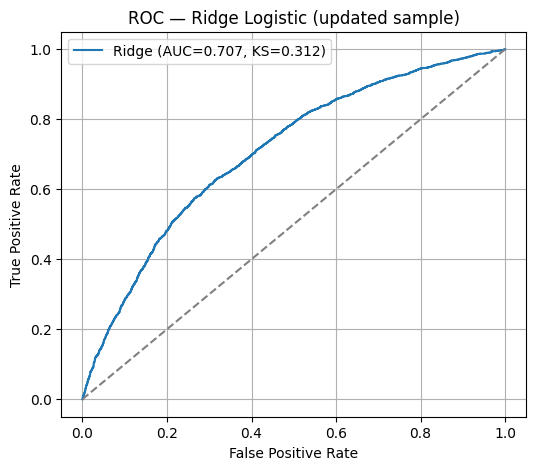

In [13]:
# === Step 7: Ridge Logistic (fast validation-tuned) ===
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 0) Build (or rebuild) transformed matrices fast
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler(with_mean=False)

Xtr = scaler.fit_transform(imputer.fit_transform(X_train))
Xva = scaler.transform(imputer.transform(X_valid))
Xte = scaler.transform(imputer.transform(X_test))

# 1) Tune C on validation
C_grid = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
val_scores = []
best_auc = -np.inf
best_C = None
best_model = None

for C in C_grid:
    clf = LogisticRegression(
        penalty='l2', solver='lbfgs',
        C=C, max_iter=500, n_jobs=-1, random_state=42
    )
    clf.fit(Xtr, y_train)
    yva_prob = clf.predict_proba(Xva)[:,1]
    auc_va = roc_auc_score(y_valid, yva_prob)
    val_scores.append((C, auc_va))
    if auc_va > best_auc:
        best_auc = auc_va
        best_C = C
        best_model = clf

print("Ridge — Validation AUC by C:", val_scores)
print(f"Ridge — Best C = {best_C} (Val AUC = {best_auc:.4f})")

# 2) Retrain on Train+Valid with best C
Xtv = np.vstack([Xtr, Xva])
y_tv = np.concatenate([y_train.values, y_valid.values])

ridge_final = LogisticRegression(
    penalty='l2', solver='lbfgs',
    C=best_C, max_iter=600, n_jobs=-1, random_state=42
)
ridge_final.fit(Xtv, y_tv)

# 3) Evaluate on test
y_prob_ridge = ridge_final.predict_proba(Xte)[:,1]
auc = roc_auc_score(y_test, y_prob_ridge)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ridge)
ks  = (tpr - fpr).max()
best_idx = (tpr - fpr).argmax()
best_thr = thresholds[best_idx]
y_pred = (y_prob_ridge >= best_thr).astype(int)
mis = 1 - accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Ridge Logistic — AUC: {auc:.4f}, KS: {ks:.4f}, Misclass: {mis:.4f}, Best thr: {best_thr:.4f}")
print("Confusion matrix (test):\n", cm)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Ridge (AUC={auc:.3f}, KS={ks:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Ridge Logistic (updated sample)")
plt.legend(); plt.grid(True)
plt.show()


KNN — Validation AUC by k: [(3, np.float64(0.8863364652442962)), (5, np.float64(0.8509338967347798)), (7, np.float64(0.8272416035339933)), (9, np.float64(0.8139576382662174)), (15, np.float64(0.7934370333416755)), (25, np.float64(0.774522023096255))]
KNN — Best k = 3 (Val AUC = 0.8863)
KNN (k=3) — AUC: 0.5910, KS: 0.1446, Misclass: 0.4390, Best thr: 0.3333
Confusion matrix (test):
 [[2150 2039]
 [1047 1793]]


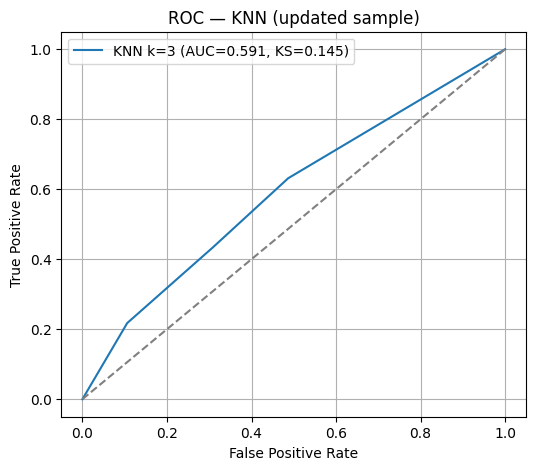

In [14]:
# === Step 8: KNN (fast, validation-tuned) ===
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 0) Build transformed matrices once (impute + scale)
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler(with_mean=False)

Xtr = scaler.fit_transform(imputer.fit_transform(X_train))
Xva = scaler.transform(imputer.transform(X_valid))
Xte = scaler.transform(imputer.transform(X_test))

# 1) Tune k on validation
k_values = [3, 5, 7, 9, 15, 25]
val_scores = []
best_auc = -np.inf
best_k = None
best_model = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(Xtr, y_train)
    yva_prob = knn.predict_proba(Xva)[:, 1]
    auc_va = roc_auc_score(y_valid, yva_prob)
    val_scores.append((k, auc_va))
    if auc_va > best_auc:
        best_auc = auc_va
        best_k = k
        best_model = knn

print("KNN — Validation AUC by k:", val_scores)
print(f"KNN — Best k = {best_k} (Val AUC = {best_auc:.4f})")

# 2) Retrain on Train+Valid with best k
Xtv = np.vstack([Xtr, Xva])
y_tv = np.concatenate([y_train.values, y_valid.values])

knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn_final.fit(Xtv, y_tv)

# 3) Evaluate on test
y_prob_knn = knn_final.predict_proba(Xte)[:, 1]
auc = roc_auc_score(y_test, y_prob_knn)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
ks  = (tpr - fpr).max()
best_idx = (tpr - fpr).argmax()
best_thr = thresholds[best_idx]
y_pred = (y_prob_knn >= best_thr).astype(int)
mis = 1 - accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"KNN (k={best_k}) — AUC: {auc:.4f}, KS: {ks:.4f}, Misclass: {mis:.4f}, Best thr: {best_thr:.4f}")
print("Confusion matrix (test):\n", cm)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"KNN k={best_k} (AUC={auc:.3f}, KS={ks:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — KNN (updated sample)")
plt.legend(); plt.grid(True)
plt.show()


XGB — Validation AUC by (n_estimators, max_depth, lr):
  (100, 3, 0.05): 0.7580
  (100, 3, 0.1): 0.7666
  (100, 4, 0.05): 0.7682
  (100, 4, 0.1): 0.7885
  (200, 3, 0.05): 0.7673
  (200, 3, 0.1): 0.7822
  (200, 4, 0.05): 0.7848
  (200, 4, 0.1): 0.8191
  (300, 3, 0.05): 0.7755
  (300, 3, 0.1): 0.7968
  (300, 4, 0.05): 0.7987
  (300, 4, 0.1): 0.8441
XGB — Best params = (300, 4, 0.1) (Val AUC = 0.8441)
XGBoost — AUC: 0.7028, KS: 0.3086, Misclass: 0.3595, Best thr: 0.3384
Confusion matrix (test):
 [[2439 1750]
 [ 777 2063]]


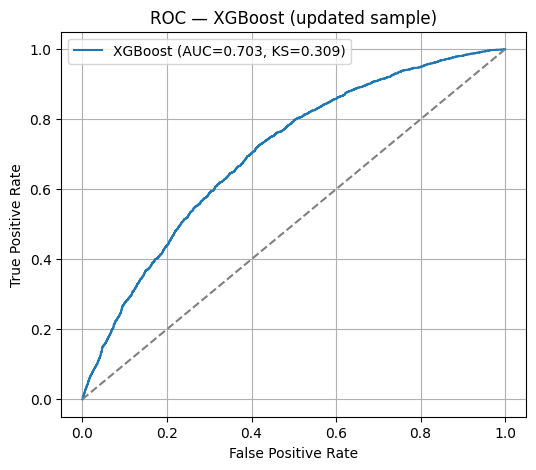

Top 15 XGB feature importances:


,importance
vol_12m,0.127956
vol_6m,0.086631
idio_vol,0.060560
industry_Finance,0.041920
PRC,0.032808
mom_3m,0.031326
log_prc,0.031034
mom_6m,0.027969
USREC,0.026788
mom_12m,0.026706


In [15]:
# === Step 9: XGBoost (fast validation-tuned) ===
# !pip install xgboost --quiet  # uncomment if xgboost isn't installed

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 0) Impute once (trees don't need scaling)
imp = SimpleImputer(strategy="median")
Xtr = imp.fit_transform(X_train)
Xva = imp.transform(X_valid)
Xte = imp.transform(X_test)

# 1) Small hyperparam grid for speed
param_grid = []
for n in [100, 200, 300]:
    for md in [3, 4]:
        for eta in [0.05, 0.1]:
            param_grid.append((n, md, eta))

val_results = []
best_auc, best_params, best_model = -np.inf, None, None

for n_estimators, max_depth, lr in param_grid:
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        reg_lambda=1.0,
        eval_metric='auc',
        n_jobs=-1,
        random_state=42
    )
    xgb.fit(Xtr, y_train)
    yva_prob = xgb.predict_proba(Xva)[:,1]
    auc_va = roc_auc_score(y_valid, yva_prob)
    val_results.append(((n_estimators, max_depth, lr), auc_va))
    if auc_va > best_auc:
        best_auc = auc_va
        best_params = (n_estimators, max_depth, lr)
        best_model = xgb

print("XGB — Validation AUC by (n_estimators, max_depth, lr):")
for p, s in val_results:
    print(f"  {p}: {s:.4f}")
print(f"XGB — Best params = {best_params} (Val AUC = {best_auc:.4f})")

# 2) Retrain on Train+Valid with best params
Xtv = np.vstack([Xtr, Xva])
y_tv = np.concatenate([y_train.values, y_valid.values])

xgb_final = XGBClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1.0,
    eval_metric='auc',
    n_jobs=-1,
    random_state=42
)
xgb_final.fit(Xtv, y_tv)

# 3) Evaluate on test
y_prob_xgb = xgb_final.predict_proba(Xte)[:,1]
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
fpr_xgb, tpr_xgb, thr_xgb = roc_curve(y_test, y_prob_xgb)
ks_xgb = (tpr_xgb - fpr_xgb).max()
best_idx = (tpr_xgb - fpr_xgb).argmax()
best_thr = thr_xgb[best_idx]
y_pred_xgb = (y_prob_xgb >= best_thr).astype(int)
mis_xgb = 1 - accuracy_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"XGBoost — AUC: {auc_xgb:.4f}, KS: {ks_xgb:.4f}, Misclass: {mis_xgb:.4f}, Best thr: {best_thr:.4f}")
print("Confusion matrix (test):\n", cm_xgb)

# ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f}, KS={ks_xgb:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — XGBoost (updated sample)")
plt.legend(); plt.grid(True)
plt.show()

# (Optional) quick feature importance view
try:
    import pandas as pd
    fi = pd.Series(xgb_final.feature_importances_, index=feature_cols).sort_values(ascending=False).head(15)
    print("Top 15 XGB feature importances:")
    display(fi.to_frame("importance"))
except Exception as e:
    print("Feature importance view skipped:", e)


In [16]:
# === Final comparison table (collects from variables you already computed) ===
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

def metrics_from_probs(name, y_true, y_prob):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    ks = (tpr - fpr).max()
    best_idx = (tpr - fpr).argmax()
    best_thr = thr[best_idx]
    y_pred = (y_prob >= best_thr).astype(int)
    mis = 1 - accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred)
    return {
        "Model": name,
        "AUC": float(auc),
        "KS": float(ks),
        "Misclass": float(mis),
        "BestThr": float(best_thr),
        "TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1]),
    }

rows = []

# 1) Logistic (baseline)
try:
    rows.append(metrics_from_probs("Logistic (baseline)", y_test, y_prob_test))
except Exception as e:
    print("Skipping Logistic (baseline):", e)

# 2) Post-LASSO (fast validation-tuned cell used variable name yte_prob)
try:
    rows.append(metrics_from_probs("Post-LASSO Logistic", y_test, yte_prob))
except Exception as e:
    print("Skipping Post-LASSO:", e)

# 3) Ridge
try:
    rows.append(metrics_from_probs("Ridge Logistic", y_test, y_prob_ridge))
except Exception as e:
    print("Skipping Ridge:", e)

# 4) KNN (only if you ran the KNN cell on this updated sample)
try:
    rows.append(metrics_from_probs("KNN (tuned)", y_test, y_prob_knn))
except Exception as e:
    print("Skipping KNN:", e)

# 5) XGBoost
try:
    rows.append(metrics_from_probs("XGBoost (tuned)", y_test, y_prob_xgb))
except Exception as e:
    print("Skipping XGBoost:", e)

results_df = pd.DataFrame(rows).sort_values("AUC", ascending=False)

cols_pretty = ["Model", "AUC", "KS", "Misclass", "BestThr", "TN", "FP", "FN", "TP"]
print("Final Model Comparison (test set)")
display(results_df[cols_pretty])


Final Model Comparison (test set)


,Model,AUC,KS,Misclass,BestThr,TN,FP,FN,TP
1,Post-LASSO Logistic,0.708918,0.316102,0.331484,0.428780,2985,1204,1126,1714
2,Ridge Logistic,0.707099,0.312390,0.337886,0.415314,2878,1311,1064,1776
4,XGBoost (tuned),0.702805,0.308648,0.359511,0.338442,2439,1750,777,2063
0,Logistic (baseline),0.693054,0.279607,0.367762,0.444199,2515,1674,911,1929
3,KNN (tuned),0.591046,0.144587,0.439038,0.333333,2150,2039,1047,1793


[LightGBM] [Info] Number of positive: 9582, number of negative: 16372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6935
[LightGBM] [Info] Number of data points in the train set: 25954, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369192 -> initscore=-0.535686
[LightGBM] [Info] Start training from score -0.535686
[LightGBM] [Info] Number of positive: 9582, number of negative: 16372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6935
[LightGBM] [Info] Number of data points in the train set: 25954, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369192 -> initscore=-0.535686
[LightGBM] [Info] Start training from score -0.535686
[LightGBM] [Wa

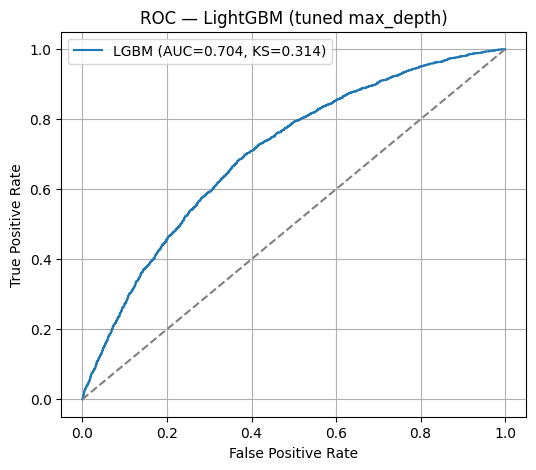


Updated comparison table:


,Model,AUC,KS,Misclass,BestThr,TN,FP,FN,TP
0,Post-LASSO Logistic,0.708918,0.316102,0.331484,0.428780,2985,1204,1126,1714
1,Ridge Logistic,0.707099,0.312390,0.337886,0.415314,2878,1311,1064,1776
5,LightGBM (tuned depth),0.703622,0.314264,0.350690,0.267365,2582,1607,858,1982
2,XGBoost (tuned),0.702805,0.308648,0.359511,0.338442,2439,1750,777,2063
3,Logistic (baseline),0.693054,0.279607,0.367762,0.444199,2515,1674,911,1929
4,KNN (tuned),0.591046,0.144587,0.439038,0.333333,2150,2039,1047,1793


In [17]:
# 1) Install + imports
# !pip install lightgbm --quiet

import numpy as np
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# 2) Trees don't need scaling; just impute once
imp = SimpleImputer(strategy="median")
Xtr = imp.fit_transform(X_train)
Xva = imp.transform(X_valid)
Xte = imp.transform(X_test)

# 3) Tune max_depth to MINIMIZE validation misclassification (2013–2017)
depth_grid = [-1, 3, 4, 5, 6, 7, 8, 9]
val_rows = []
best = {"depth": None, "mis": 1e9, "thr": None, "model": None}

for d in depth_grid:
    lgb = LGBMClassifier(
        objective="binary",
        n_estimators=500,
        learning_rate=0.05,
        max_depth=d,
        num_leaves=2**max(d,1),  # simple coupling; ignored if d=-1
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42
    )
    lgb.fit(Xtr, y_train)
    yva_prob = lgb.predict_proba(Xva)[:,1]

    # Use KS-optimal threshold on validation to compute misclassification (consistent with earlier steps)
    fpr, tpr, thr = roc_curve(y_valid, yva_prob)
    ks_idx = (tpr - fpr).argmax()
    thr_va = thr[ks_idx]
    yva_pred = (yva_prob >= thr_va).astype(int)
    mis_va = 1 - accuracy_score(y_valid, yva_pred)
    auc_va = roc_auc_score(y_valid, yva_prob)

    val_rows.append((d, auc_va, mis_va, float(thr_va)))
    if mis_va < best["mis"]:
        best = {"depth": d, "mis": mis_va, "thr": float(thr_va), "model": lgb}

print("LightGBM — Validation metrics by max_depth (AUC, Misclassification, KS-threshold):")
for d, a, m, t in val_rows:
    print(f"  depth={d:>2}: val AUC={a:.4f}, val Mis={m:.4f}, val Thr(KS)={t:.4f}")
print(f"\nBest max_depth = {best['depth']} (val Mis={best['mis']:.4f}, val Thr={best['thr']:.4f})")

# 4) Retrain on Train+Valid using best depth
Xtv = np.vstack([Xtr, Xva])
y_tv = np.concatenate([y_train.values, y_valid.values])

lgb_final = LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=best["depth"],
    num_leaves=2**max(best["depth"],1) if best["depth"] != -1 else 31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42
)
lgb_final.fit(Xtv, y_tv)

# 5) Evaluate on Test (2018–2023)
yte_prob_lgb = lgb_final.predict_proba(Xte)[:,1]

# AUC/KS
auc_lgb = roc_auc_score(y_test, yte_prob_lgb)
fpr, tpr, thr = roc_curve(y_test, yte_prob_lgb)
ks_lgb = (tpr - fpr).max()

# Misclassification (A) at TEST KS-optimal threshold (consistent with other models you reported)
ks_idx = (tpr - fpr).argmax()
thr_te_ks = thr[ks_idx]
yte_pred_ks = (yte_prob_lgb >= thr_te_ks).astype(int)
mis_te_ks = 1 - accuracy_score(y_test, yte_pred_ks)
cm_te_ks  = confusion_matrix(y_test, yte_pred_ks)

# Misclassification (B) using the VALIDATION threshold you selected (to mirror the PDF’s step)
thr_from_val = best["thr"]
yte_pred_valthr = (yte_prob_lgb >= thr_from_val).astype(int)
mis_te_valthr = 1 - accuracy_score(y_test, yte_pred_valthr)

print(f"\nLightGBM (best depth={best['depth']}) — TEST metrics")
print(f"AUC={auc_lgb:.4f}, KS={ks_lgb:.4f}")
print(f"Misclass (test @ KS-opt thr on test)   = {mis_te_ks:.4f}, thr={thr_te_ks:.4f}")
print(f"Misclass (test @ validation-chosen thr)= {mis_te_valthr:.4f}, thr={thr_from_val:.4f}")
print("Confusion matrix (test @ KS-opt thr):\n", cm_te_ks)

# Optional: quick ROC plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LGBM (AUC={auc_lgb:.3f}, KS={ks_lgb:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — LightGBM (tuned max_depth)")
plt.legend(); plt.grid(True)
plt.show()

# 6) (Optional) Add to your comparison table if it's in memory
try:
    import pandas as pd
    def row(name, y_true, y_prob):
        fpr_, tpr_, thr_ = roc_curve(y_true, y_prob)
        auc_ = roc_auc_score(y_true, y_prob)
        ks_  = (tpr_ - fpr_).max()
        ks_idx_ = (tpr_ - fpr_).argmax()
        thr_best_ = thr_[ks_idx_]
        y_pred_ = (y_prob >= thr_best_).astype(int)
        mis_ = 1 - accuracy_score(y_true, y_pred_)
        cm_  = confusion_matrix(y_true, y_pred_)
        return {"Model": name, "AUC": float(auc_), "KS": float(ks_), "Misclass": float(mis_),
                "BestThr": float(thr_best_), "TN": int(cm_[0,0]), "FP": int(cm_[0,1]), "FN": int(cm_[1,0]), "TP": int(cm_[1,1])}
    lgb_row = row("LightGBM (tuned depth)", y_test, yte_prob_lgb)
    if 'results_df' in globals():
        results_df = pd.concat([results_df, pd.DataFrame([lgb_row])], ignore_index=True).sort_values("AUC", ascending=False)
        print("\nUpdated comparison table:")
        display(results_df[["Model","AUC","KS","Misclass","BestThr","TN","FP","FN","TP"]])
    else:
        print("\nLightGBM summary row:")
        display(pd.DataFrame([lgb_row]))
except Exception as e:
    print("Skipped comparison table update:", e)
